# Create climate dataset for capitals in Europe

In [26]:
import xarray as xr
import matplotlib.pyplot as plt
import cfgrib
import pandas as pd
import numpy as np
%matplotlib inline

# to resolve xarray FutureWarning
xr.set_options(use_new_combine_kwarg_defaults=True)

In [27]:
# Check all available datasets first
eu_capitals = pd.read_csv("datasets/european_cities.csv")
print(eu_capitals.shape)
eu_capitals.head()

(300, 3)


,name,latitude,longitude
0,Aachen,50.776642,6.08342
1,Aberdeen,57.143688,-2.09814
2,Aix-en-Provence,43.528301,5.44973
3,Alcalá de Henares,40.482052,-3.35996
4,Alicante,38.345169,-0.48149


In [28]:
bern = eu_capitals[eu_capitals['name'] == 'Bern']
display(bern)

,name,latitude,longitude
26,Bern,46.94809,7.44744


In [29]:
# Check all available datasets first
all_datasets = cfgrib.open_datasets("1970_2020.grib")
print(f"Number of datasets: {len(all_datasets)}\n")

for i, dataset in enumerate(all_datasets):
    print(f"Dataset {i}:")
    print(f"  Variables: {list(dataset.data_vars)}")
    print(f"  Dimensions: {dict(dataset.sizes)}")

Number of datasets: 2

Dataset 0:
  Variables: ['sf', 'tp']
  Dimensions: {'time': 612, 'latitude': 149, 'longitude': 281}
Dataset 1:
  Variables: ['t2m', 'si10']
  Dimensions: {'time': 612, 'latitude': 149, 'longitude': 281}


In [30]:
all_datasets = cfgrib.open_datasets("1970_2020.grib")

# Dataset 0 contains: sf, tp
# Dataset 1 contains: t2m, si10
# Each dictionary entry is a cube
ds = {
    'sf': all_datasets[0].sf,
    'tp': all_datasets[0].tp,
    't2m': all_datasets[1].t2m,
    'si10': all_datasets[1].si10
}

print("Loaded variables:", list(ds.keys()))
print(f"Dimensions: time={len(all_datasets[0].time)}, lat={len(all_datasets[0].latitude)}, lon={len(all_datasets[0].longitude)}")

Loaded variables: ['sf', 'tp', 't2m', 'si10']
Dimensions: time=612, lat=149, lon=281


Tha data retrieved from Copernicus are in the form of 4D-hypercubes with dimensions: feature, time, latitude, longitude (4 x 612 x 58 x 58). To visualize it, you can think of a 3D cube linked to each feature (sf, tp, t2m, si10). The 3 dimensions are: time (monthly data from 1970 to 2020), latitude, longitude.

![](images/data_cubes.png)

In [31]:
features = ["sf", "t2m", "tp", "si10"]

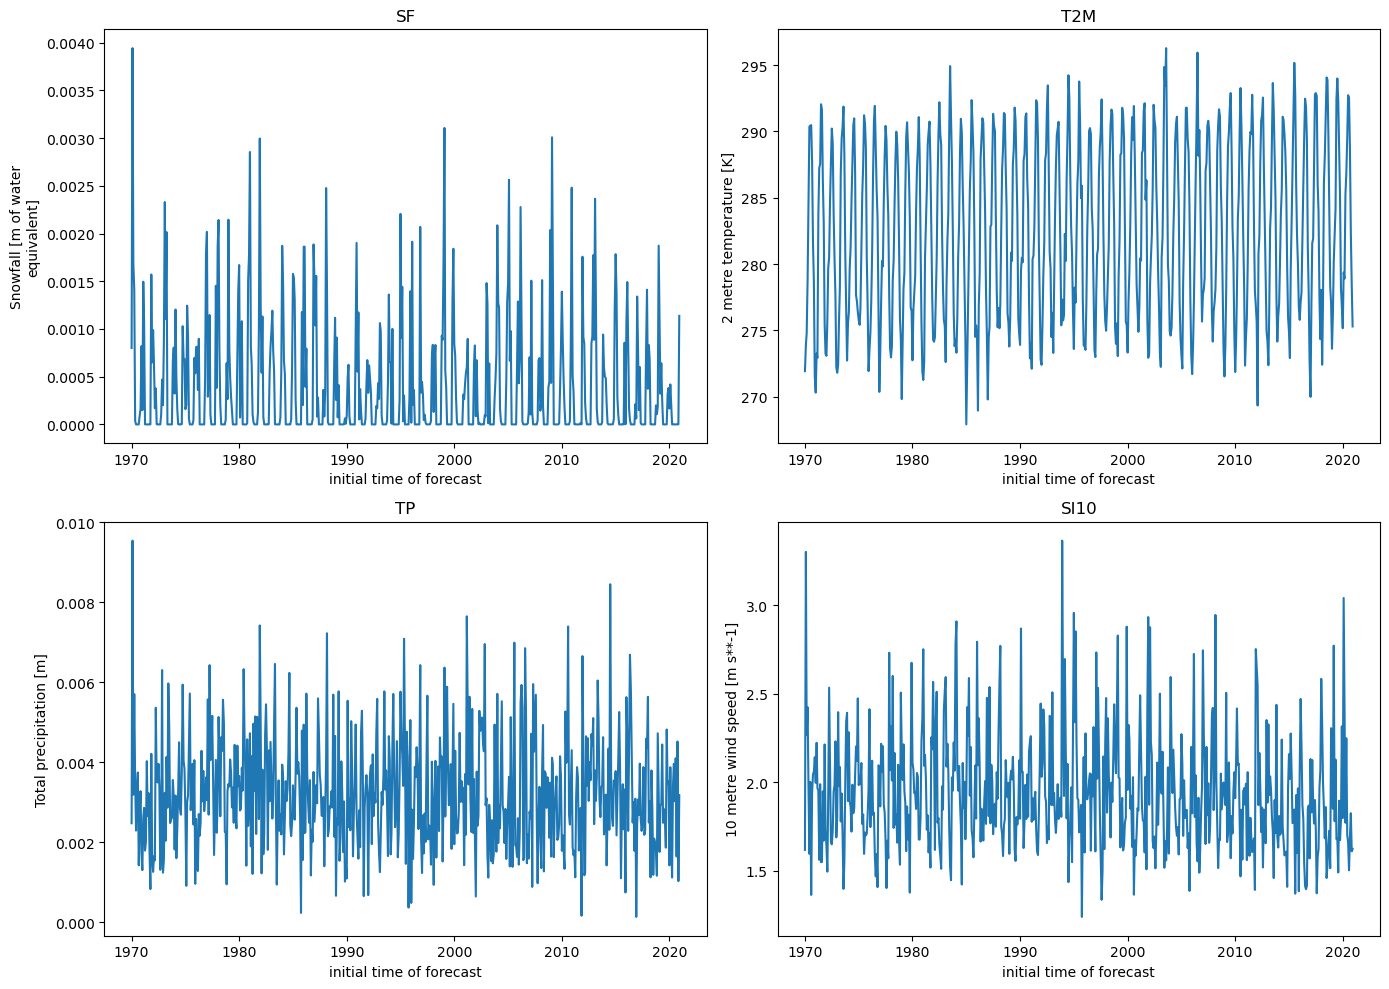

In [32]:
# Plot time series for each feature at Bern's location

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feat in enumerate(features):
    ds[feat].sel(longitude=bern.longitude.values[0], latitude=bern.latitude.values[0], method='nearest').plot(ax=axes[i])
    axes[i].set_title(f'{feat.upper()}')

plt.tight_layout()
plt.show()

In [33]:
ds["sf"].sel(longitude=bern.longitude.values[0], latitude=bern.latitude.values[0], method='nearest')

<xarray.DataArray 'sf' (time: 612)> Size: 2kB
[612 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 5kB 1969-12-31T18:00:00 ... 2020-11-30T...
    number      int64 8B 0
    step        timedelta64[ns] 8B 12:00:00
    surface     float64 8B 0.0
    latitude    float64 8B 47.0
    longitude   float64 8B 7.5
    valid_time  (time) datetime64[ns] 5kB ...
Attributes: (12/31)
    GRIB_paramId:                             144
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      41869
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_shortName:                           sf
    GRIB_totalNumber:                         0
    GRIB_units:                               m of water equivalent
    long_name:                                Snowfall
    units:                                    m of water equivalent
    standard_name:                            lwe_thickness_of_snowfall_amount

In [34]:
radius = 0.45

# capitales triées
eu_cap = eu_capitals.sort_values(["latitude", "longitude"])

# limites du dataset
lat_min_ds = ds[features[0]].latitude.min().item()
lat_max_ds = ds[features[0]].latitude.max().item()
lon_min_ds = ds[features[0]].longitude.min().item()
lon_max_ds = ds[features[0]].longitude.max().item()

# filtrer les capitales valides
eu_cap = eu_cap[
    (eu_cap['latitude'] >= lat_min_ds) & (eu_cap['latitude'] <= lat_max_ds) &
    (eu_cap['longitude'] >= lon_min_ds) & (eu_cap['longitude'] <= lon_max_ds)
].reset_index(drop=True)

lats = eu_cap["latitude"].values
lons = eu_cap["longitude"].values
names = eu_cap["name"].values

# grille du dataset
lat_ds = ds[features[0]].latitude.values
lon_ds = ds[features[0]].longitude.values

# pré-calcul des indices valides pour chaque capitale
lat_ranges = []
lon_ranges = []

for lat in lats:
    lat_min = lat - radius
    lat_max = lat + radius
    # latitude décroissante
    lat_idx = np.where((lat_ds <= lat_max) & (lat_ds >= lat_min))[0]
    lat_ranges.append(lat_idx)

for lon in lons:
    lon_min = lon - radius
    lon_max = lon + radius
    lon_idx = np.where((lon_ds >= lon_min) & (lon_ds <= lon_max))[0]
    lon_ranges.append(lon_idx)


ds_capitals = {}

for feat in features:
    print(f"Processing feature: {feat}")
    data = ds[feat].values   # (time, 149, 281)
    T, Y, X = data.shape

    out = np.empty((T, len(lats), len(lons)), dtype=np.float32)

    for i in range(len(lats)):
        lat_idx = lat_ranges[i]

        for j in range(len(lons)):
            lon_idx = lon_ranges[j]

            block = data[:, lat_idx[:, None], lon_idx]   # (time, nlat, nlon)

            # moyenne spatiale
            out[:, i, j] = np.nanmean(block, axis=(1, 2))
            if np.isnan(out[:, i, j]).any():
                print(f"Warning: NaN values for feature {feat} at capital index ({i}, {j})")

    ds_capitals[feat] = xr.DataArray(
        out,
        dims=("time", "latitude", "longitude"),
        coords={
            "time": ds[feat].time.values,
            "latitude": lats,
            "longitude": lons
        }
    )


Processing feature: sf
Processing feature: t2m
Processing feature: tp
Processing feature: si10


In [35]:
# Verification
print(f"Original dims: {ds['t2m'].dims}")
print(f"Original shape: {ds['t2m'].shape}")
print(f"Subset dims: {ds_capitals['t2m'].dims}")
print(f"Subset shape: {ds_capitals['t2m'].shape}")

print(f"\nData for first capital ({names[0]}):")
print(f"Latitude: {ds_capitals['t2m'].latitude.values[0]}")
print(f"Longitude: {ds_capitals['t2m'].longitude.values[0]}")
print(f"Mean value: {ds_capitals['t2m'].values[0]}")

Original dims: ('time', 'latitude', 'longitude')
Original shape: (612, 149, 281)
Subset dims: ('time', 'latitude', 'longitude')
Subset shape: (612, 292, 292)

Data for first capital (Marbella):
Latitude: 36.51543
Longitude: -4.88583
Mean value: [[285.62344 286.79077 286.73364 ... 286.93954 288.6643  287.1279 ]
 [284.93726 286.62012 285.5603  ... 286.8702  288.59595 287.02158]
 [284.04404 286.37442 284.75107 ... 286.75854 288.525   286.91785]
 ...
 [278.62964 278.60165 278.5852  ... 261.91153 278.52808 261.6509 ]
 [276.48755 276.45532 276.53845 ... 263.73007 272.19177 261.6669 ]
 [276.06274 275.87036 276.11533 ... 265.87616 270.1705  262.80283]]


In [36]:
# We see that we still have 612 time steps for 58 lat/lon = capitals
ds_capitals["t2m"]

<xarray.DataArray (time: 612, latitude: 292, longitude: 292)> Size: 209MB
array([[[285.62344, 286.79077, 286.73364, ..., 286.93954, 288.6643 ,
         287.1279 ],
        [284.93726, 286.62012, 285.5603 , ..., 286.8702 , 288.59595,
         287.02158],
        [284.04404, 286.37442, 284.75107, ..., 286.75854, 288.525  ,
         286.91785],
        ...,
        [278.62964, 278.60165, 278.5852 , ..., 261.91153, 278.52808,
         261.6509 ],
        [276.48755, 276.45532, 276.53845, ..., 263.73007, 272.19177,
         261.6669 ],
        [276.06274, 275.87036, 276.11533, ..., 265.87616, 270.1705 ,
         262.80283]],

       [[285.33383, 285.88333, 286.36917, ..., 286.91592, 286.90805,
         287.30917],
        [284.66763, 285.7499 , 285.24844, ..., 286.86948, 286.85318,
         287.23163],
        [283.81464, 285.51157, 284.48422, ..., 286.78986, 286.79544,
         287.15833],
...
        [281.25497, 281.11987, 281.27676, ..., 276.93353, 279.8046 ,
         276.83957],
        [278.9942 , 278.92694, 279.06012, ..., 276.27042, 274.95404,
         274.70532],
        [278.56192, 278.32706, 278.67212, ..., 277.59998, 273.4415 ,
         274.7645 ]],

       [[286.02417, 286.76782, 287.19882, ..., 289.28235, 289.86157,
         289.64563],
        [285.22278, 286.4994 , 285.91943, ..., 289.25073, 289.807  ,
         289.56064],
        [284.204  , 286.1075 , 285.0009 , ..., 289.17755, 289.7538 ,
         289.48938],
        ...,
        [280.05493, 279.87265, 280.12656, ..., 273.35312, 278.7859 ,
         273.0966 ],
        [277.7732 , 277.47742, 277.91064, ..., 272.69296, 274.12744,
         271.33408],
        [277.41724, 277.0896 , 277.53946, ..., 273.8121 , 272.43726,
         270.8744 ]]], shape=(612, 292, 292), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2020-12-01
  * latitude   (latitude) float64 2kB 36.52 36.69 36.72 ... 61.5 64.14 65.01
  * longitude  (longitude) float64 2kB -4.886 -6.136 -4.42 ... 23.79 -21.9 25.47

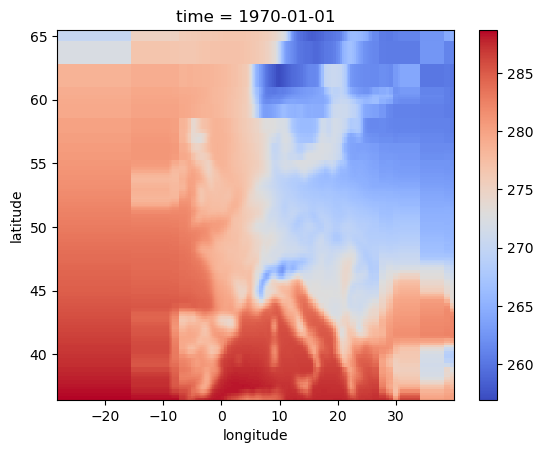

In [37]:
# Plot the temperature data for the first time step across all capitals
ds_capitals["t2m"][0].sortby(['latitude', 'longitude']).plot(cmap=plt.cm.coolwarm)

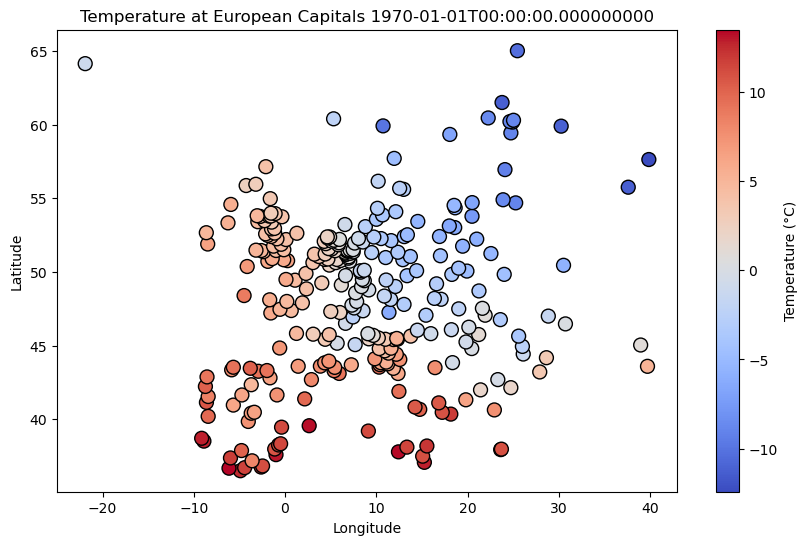

In [38]:
plt.figure(figsize=(10, 6))

# Extract the diagonal values (matching lat/lon pairs)
temps = np.diag(ds_capitals["t2m"][0].values) - 273.15  # Convert Kelvin to Celsius
lats = ds_capitals["t2m"].latitude.values
lons = ds_capitals["t2m"].longitude.values

plt.scatter(lons, lats, c=temps, cmap=plt.cm.coolwarm, s=100, edgecolors='black')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Temperature at European Capitals {ds_capitals["t2m"].time.values[0]}')
plt.show()

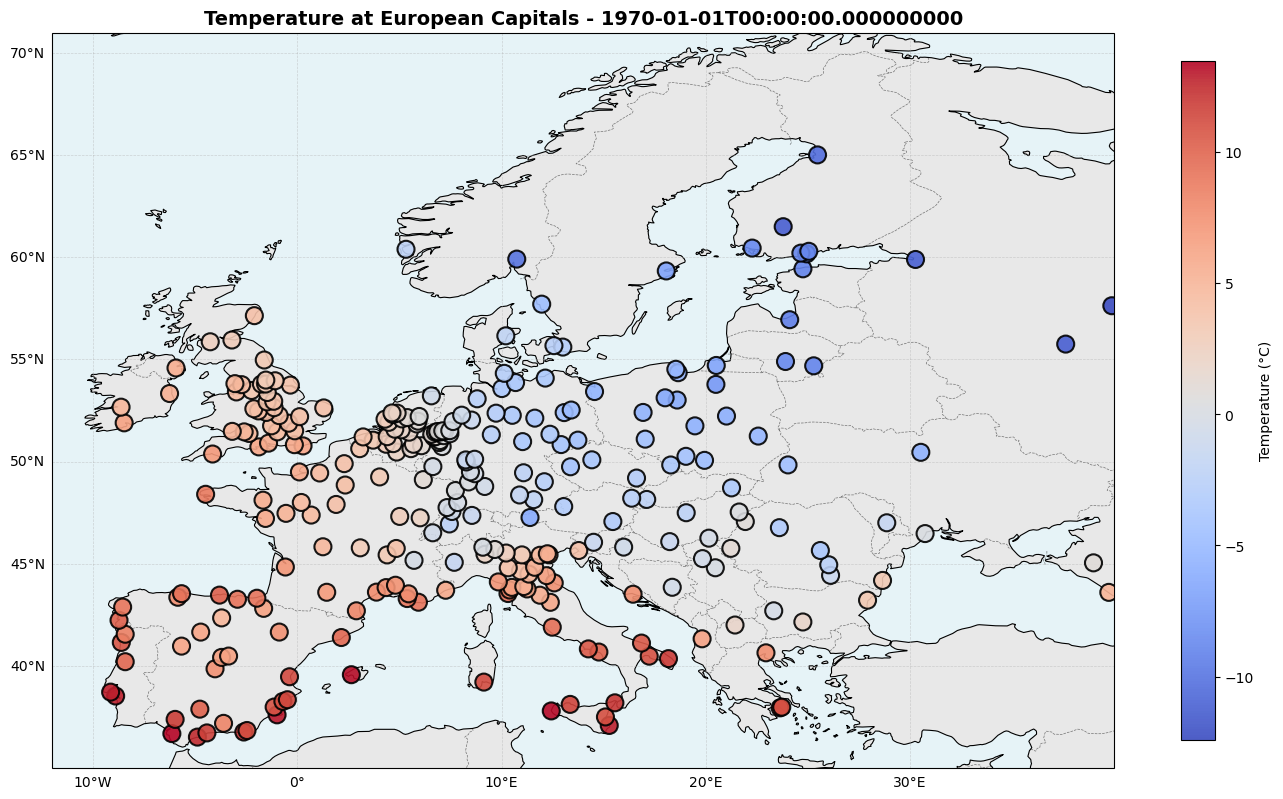

In [39]:
# Enhanced plot with Cartopy for better geographical representation

import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Extract the diagonal values (matching lat/lon pairs)
temps = np.diag(ds_capitals["t2m"][0].values) - 273.15  # Convert Kelvin to Celsius
lats = ds_capitals["t2m"].latitude.values
lons = ds_capitals["t2m"].longitude.values

# Plot scatter with correct transform
scatter = ax.scatter(lons, lats, c=temps, cmap='coolwarm', s=150, 
                        edgecolors='black', linewidths=1.5, 
                        transform=ccrs.PlateCarree(), zorder=5, alpha=0.9)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Temperature (°C)', shrink=0.7, pad=0.05)

# Set extent to focus on Europe (West, East, South, North)
ax.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title(f'Temperature at European Capitals - {ds_capitals["t2m"].time.values[0]}', 
                fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Average climate features for each decade

For each feature, for each capital (lat,lon), do the mean on 10 years for each month. For example, for the feature "2m temperature" (t2m), for the capital of France (48.8566, 2.3522), do the mean of all January data from 1970 to 1979, then do the mean of all February data from 1970 to 1979, and so on until December. Then repeat the same operation for the periods 1980-1989, 1990-1999, 2000-2009 and 2010-2020. In the end, we will have for each year, a dataset with 2 + 12 * 4 = 50 columns: latitude, longitude, and for each month (12) the 4 features (sf, tp, t2m, si10).

<img src="images/ds_columns_past_v2.png" style="width:1000px;"  />


In [40]:
# Define the periods for averaging
periods = [
    ('1970-1979', '1970-01', '1979-12'),
    ('1980-1989', '1980-01', '1989-12'),
    ('1990-1999', '1990-01', '1999-12'),
    ('2000-2009', '2000-01', '2009-12'),
    ('2010-2020', '2010-01', '2020-12')
]

# Define season mapping
def get_season(month):
    """Map month number to season name"""
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # month in [9, 10, 11]
        return 'autumn'

# Dictionary to store separate DataFrames for each period
period_datasets = {}

for period_name, start_date, end_date in periods:
    print(f"Processing period: {period_name}")
    
    # List to store data for each capital
    capital_data = []
    
    # Iterate over each capital
    for idx in range(len(lats)):
        lat = lats[idx]
        lon = lons[idx]
        name = names[idx]
        
        # Dictionary to store this capital's data
        row_data = {
            'city': name,
            'latitude': lat,
            'longitude': lon
        }
        
        # For each feature, calculate seasonal averages
        for feat in features:
            # Select data for this capital and time period
            # Extract diagonal to get the correct lat/lon pair
            data_period = ds_capitals[feat].sel(time=slice(start_date, end_date))
            
            # Get the diagonal values for this capital across all time steps in the period
            capital_timeseries = data_period.values[:, idx, idx]
            
            # Get the time index
            time_index = data_period.time.values
            
            # Convert to pandas Series for easier grouping by season
            ts = pd.Series(capital_timeseries, index=pd.DatetimeIndex(time_index))
            
            # Map months to seasons and group by season
            seasons = ts.index.month.map(get_season)
            seasonal_means = ts.groupby(seasons).mean()
            
            # Store each season's mean with column name like 'sf_winter', 'sf_spring', etc.
            season_names = ['winter', 'spring', 'summer', 'autumn']
            
            for season_name in season_names:
                if season_name in seasonal_means.index:
                    row_data[f'{feat}_{season_name}'] = seasonal_means[season_name]
                else:
                    row_data[f'{feat}_{season_name}'] = np.nan


             # For t2m, also calculate max and min per season
            if feat == 't2m':
                seasonal_max = ts.groupby(seasons).max()
                seasonal_min = ts.groupby(seasons).min()
                
                for season_name in season_names:
                    if season_name in seasonal_max.index:
                        row_data[f'max_t2m_{season_name}'] = seasonal_max[season_name]
                    else:
                        row_data[f'max_t2m_{season_name}'] = np.nan
                    
                    if season_name in seasonal_min.index:
                        row_data[f'min_t2m_{season_name}'] = seasonal_min[season_name]
                    else:
                        row_data[f'min_t2m_{season_name}'] = np.nan
        
        capital_data.append(row_data)
    
    # Create DataFrame for this period
    period_df = pd.DataFrame(capital_data)
    period_datasets[period_name] = period_df
    print(f"  Shape: {period_df.shape}")

print(f"\nCreated {len(period_datasets)} separate DataFrames")
print(f"Available periods: {list(period_datasets.keys())}")
print(f"\nExample - First few rows of 1970-1979:")
period_datasets['1970-1979'].head()

Processing period: 1970-1979
  Shape: (292, 27)
Processing period: 1980-1989
  Shape: (292, 27)
Processing period: 1990-1999
  Shape: (292, 27)
Processing period: 2000-2009
  Shape: (292, 27)
Processing period: 2010-2020
  Shape: (292, 27)

Created 5 separate DataFrames
Available periods: ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2020']

Example - First few rows of 1970-1979:


,city,latitude,longitude,sf_winter,sf_spring,sf_summer,sf_autumn,t2m_winter,t2m_spring,t2m_summer,...,max_t2m_autumn,min_t2m_autumn,tp_winter,tp_spring,tp_summer,tp_autumn,si10_winter,si10_spring,si10_summer,si10_autumn
0,Marbella,36.515430,-4.88583,1.096990e-05,0.000000e+00,0.0,0.000009,284.919525,287.198761,294.689972,...,295.139984,285.643311,0.002565,0.001479,0.000409,0.002737,4.359142,4.195480,3.462208,3.843167
1,Jerez de la Frontera,36.686451,-6.13606,1.390775e-08,0.000000e+00,0.0,0.000000,285.587006,288.368164,296.063660,...,297.625000,285.998627,0.002811,0.001466,0.000360,0.002322,4.299484,4.131361,3.587830,3.921852
2,Málaga,36.720161,-4.42034,2.423127e-05,6.794929e-07,0.0,0.000022,283.982605,286.754944,294.773285,...,294.954254,284.587982,0.002176,0.001453,0.000368,0.002280,3.692780,3.507616,2.764400,3.146905
3,Roquetas de Mar,36.764191,-2.61475,5.542835e-05,5.953842e-06,0.0,0.000045,284.594055,287.243927,295.400513,...,295.978851,285.311127,0.001366,0.001051,0.000361,0.001743,4.569746,4.532565,3.830574,4.118082
4,Almería,36.838139,-2.45974,1.043452e-04,1.787080e-05,0.0,0.000078,283.467957,286.564392,295.168060,...,295.502289,283.930908,0.001322,0.001226,0.000496,0.001766,4.054773,4.049181,3.474088,3.665426


In [41]:
# Display info about each period dataset
for period_name, df in period_datasets.items():
    print(f"\n{period_name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {df.shape[1]}")
    
# Example: Access a specific period and show first 5 and last 5 rows
print("\n" + "="*50)
print("Example - Dataset for 2000-2009:")
print("\nFirst 5 rows:")
display(period_datasets['2000-2009'].head())
print("\nLast 5 rows:")
display(period_datasets['2000-2009'].tail())


1970-1979:
  Shape: (292, 27)
  Columns: 27

1980-1989:
  Shape: (292, 27)
  Columns: 27

1990-1999:
  Shape: (292, 27)
  Columns: 27

2000-2009:
  Shape: (292, 27)
  Columns: 27

2010-2020:
  Shape: (292, 27)
  Columns: 27

Example - Dataset for 2000-2009:

First 5 rows:


,city,latitude,longitude,sf_winter,sf_spring,sf_summer,sf_autumn,t2m_winter,t2m_spring,t2m_summer,...,max_t2m_autumn,min_t2m_autumn,tp_winter,tp_spring,tp_summer,tp_autumn,si10_winter,si10_spring,si10_summer,si10_autumn
0,Marbella,36.515430,-4.88583,1.204544e-05,0.000000e+00,0.0,0.000002,285.138275,288.550598,296.045349,...,295.007660,285.905121,0.002248,0.001046,0.000423,0.002932,4.251797,4.091252,3.556007,3.640091
1,Jerez de la Frontera,36.686451,-6.13606,4.967054e-09,0.000000e+00,0.0,0.000000,285.768402,289.974396,297.688873,...,297.000977,286.424713,0.002297,0.001153,0.000490,0.003057,4.097005,4.255558,3.806457,3.826045
2,Málaga,36.720161,-4.42034,2.099143e-05,6.622738e-09,0.0,0.000003,284.271942,288.257385,296.361816,...,294.933258,284.951843,0.001862,0.001031,0.000353,0.002446,3.613074,3.430300,2.787080,3.044610
3,Roquetas de Mar,36.764191,-2.61475,6.368160e-05,1.317925e-06,0.0,0.000019,284.855988,288.695587,296.880035,...,295.713531,285.887543,0.001095,0.000737,0.000364,0.001447,4.317682,4.472522,3.866503,4.044622
4,Almería,36.838139,-2.45974,1.255857e-04,3.723966e-06,0.0,0.000033,283.788635,288.171051,296.831177,...,295.407379,284.655304,0.001112,0.000861,0.000489,0.001483,3.852906,4.007588,3.529816,3.615545



Last 5 rows:


,city,latitude,longitude,sf_winter,sf_spring,sf_summer,sf_autumn,t2m_winter,t2m_spring,t2m_summer,...,max_t2m_autumn,min_t2m_autumn,tp_winter,tp_spring,tp_summer,tp_autumn,si10_winter,si10_spring,si10_summer,si10_autumn
287,Bergen,60.392990,5.324150,0.002441,0.000268,1.011292e-06,0.000857,274.762695,278.810486,286.968719,...,287.624390,274.824829,0.007048,0.004586,0.006918,0.008757,4.620561,3.767627,3.336106,4.382265
288,Turku,60.451481,22.268690,0.000887,0.000065,0.000000e+00,0.000494,270.319336,277.312958,289.189178,...,287.098358,271.264771,0.001394,0.001570,0.002480,0.002154,4.230444,3.627116,3.473040,4.097988
289,Tampere,61.499111,23.787121,0.001018,0.000107,1.059638e-08,0.000686,268.421326,276.867279,288.759766,...,285.753540,268.827911,0.001246,0.001772,0.002419,0.001967,3.575434,3.191834,2.961169,3.496774
290,Reykjavík,64.135483,-21.895411,0.001564,0.000246,1.448443e-05,0.000899,273.672089,277.105164,284.116333,...,283.283447,273.731812,0.004672,0.003191,0.004191,0.004765,5.415030,4.878969,3.901844,5.119232
291,Oulu,65.012360,25.468161,0.001098,0.000207,7.179048e-07,0.000716,265.809021,274.691406,287.964996,...,284.064301,265.837677,0.001232,0.001672,0.002424,0.001696,3.907233,3.433169,3.105353,3.939937


In [42]:
# Check for any missing values in each period dataset
for period_name, df in period_datasets.items():
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()
    print(f"\n{period_name}:")
    print(f"  Total missing values: {total_missing}")
    if total_missing > 0:
        print("  Missing values per column:")
        print(missing_counts[missing_counts > 0])


1970-1979:
  Total missing values: 0

1980-1989:
  Total missing values: 0

1990-1999:
  Total missing values: 0

2000-2009:
  Total missing values: 0

2010-2020:
  Total missing values: 0


In [43]:
# Download the datasets as CSV files
for period_name, df in period_datasets.items():
    df.to_csv(f"datasets/climate_features_{period_name}_v2.csv", index=False)
    print(f"Saved climate_features_{period_name}_v2.csv")

Saved climate_features_1970-1979_v2.csv
Saved climate_features_1980-1989_v2.csv
Saved climate_features_1990-1999_v2.csv
Saved climate_features_2000-2009_v2.csv
Saved climate_features_2010-2020_v2.csv
